In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [149]:
data = pd.read_csv(r'insurance.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


There are no missing values

# Converting text values to numerical values

In [160]:
text_to_num={"female":0,"male":1,"yes":1,"no":0,"southwest":0,'southeast':1,'northwest':2,'northeast':3}
data1=data.copy()
data1.replace(text_to_num,inplace=True)
data.replace(text_to_num,inplace=True)

# Computing and ploting pairwise correlation of data

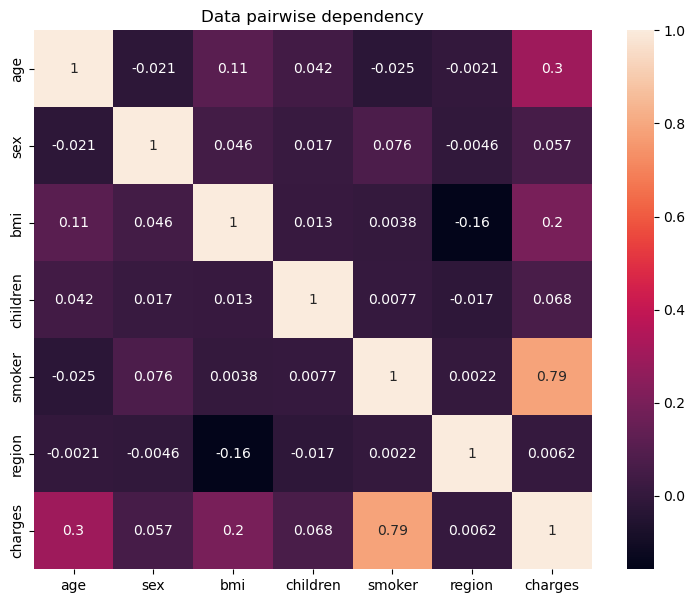

In [4]:
corr = data1.corr()
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(corr,annot=True)
plt.title("Data pairwise dependency")
plt.show()

From heatmap we conclude that age, bmi and whether the client is smoker or not affect the charges the most.

<Axes: title={'center': 'Age vs Charge'}, xlabel='age', ylabel='charges'>

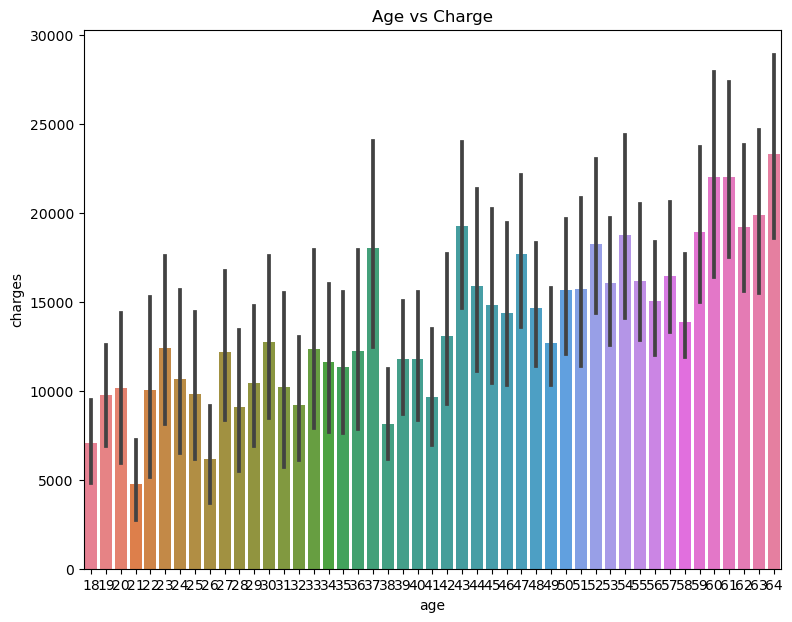

In [5]:
plt.figure(figsize=(9,7))
plt.title('Age vs Charge')
sns.barplot(x='age',y='charges',data=data1,palette='husl')

Text(0.5, 1.0, 'BMI VS Charge')

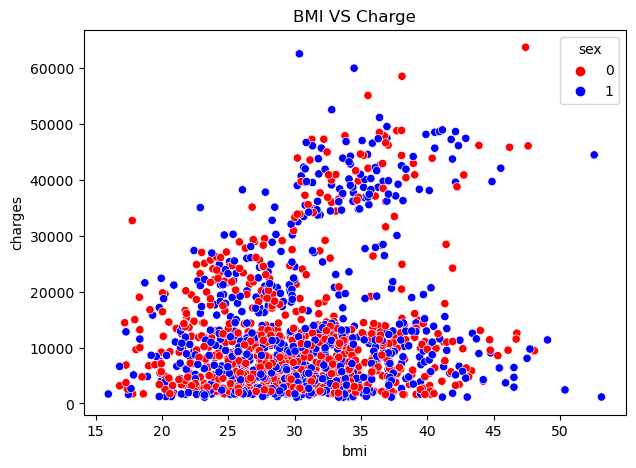

In [6]:
plt.figure(figsize=(7,5))
colors = {0:'red',1:'blue'}
sns.scatterplot(x='bmi',y='charges',hue='sex',data=data1,palette=colors)
plt.title('BMI VS Charge')

<Axes: title={'center': 'Smoker vs Charge'}, xlabel='smoker', ylabel='charges'>

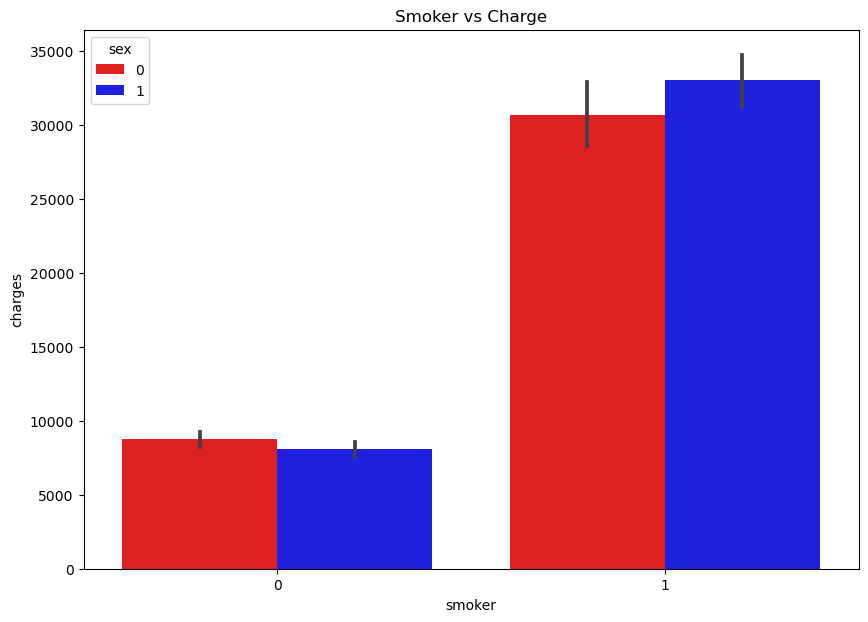

In [7]:
plt.figure(figsize=(10,7))
plt.title('Smoker vs Charge')
sns.barplot(x='smoker',y='charges',data=data1,palette=colors,hue='sex')

# Scaling and setting up the data

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
bmi,charges,age=data1['bmi'].values.reshape(-1,1),data1['charges'].values.reshape(-1,1),data1['age'].values.reshape(-1,1)
data_scaled = data1.copy()
data_scaled['bmi'],data_scaled['charges'],data_scaled['age'] = scaler.fit_transform(bmi),scaler.fit_transform(charges),scaler.fit_transform(age)
data_scaled.head()

,age,sex,bmi,children,smoker,region,charges
0,-1.438764,0,-0.453320,0,1,0,0.298584
1,-1.509965,1,0.509621,1,0,1,-0.953689
2,-0.797954,1,0.383307,3,0,1,-0.728675
3,-0.441948,1,-1.305531,0,0,2,0.719843
4,-0.513149,1,-0.292556,0,0,2,-0.776802


In [9]:
from sklearn.model_selection import train_test_split
x = data_scaled.drop('charges',axis=1).values
y=data_scaled['charges'].values
x_train, x_test,y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=1)
x_test_scaled = scaler.fit_transform(x_test)

# Linear regression

In [10]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
lin.fit(x_train,y_train)

LinearRegression()

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
cv_lin = cross_val_score(estimator=lin, X=x,y=y,cv=10)
ytrainpredict_lin = lin.predict(x_train)
ytestpredict_lin = lin.predict(x_test)
print("Cross val score:", cv_lin.mean())
print("r2 score train:", r2_score(y_train,ytrainpredict_lin))
print("r2 score test:", r2_score(y_test,ytestpredict_lin))

Cross val score: 0.7448047213193172
r2 score train: 0.7475615631933097
r2 score test: 0.762322402256339


# Ridge and Lasso regression

In [12]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
lass = linear_model.Lasso()
ridge = linear_model.Ridge()
parameters = {'alpha':[1e-5,1,10,0.1,0.01,0.001,20],'random_state':[1]}
lass_grid = GridSearchCV(estimator=lass,param_grid=parameters,cv=10,verbose= False,n_jobs=-1)
ridge_grid = GridSearchCV(estimator=ridge,param_grid=parameters,cv=10,verbose= False,n_jobs=-1)
x_train_scaled = scaler.fit_transform(x_train)


lass_grid.fit(x_train_scaled,y_train)
ridge_grid.fit(x_train_scaled,y_train)
print(lass_grid.best_params_,lass_grid.best_score_)
print(ridge_grid.best_params_,ridge_grid.best_score_)

{'alpha': 0.001, 'random_state': 1} 0.7375540458378429
{'alpha': 10, 'random_state': 1} 0.7376083183246578


In [22]:
lass = linear_model.Lasso(alpha= 0.001,random_state=1)
ridge = linear_model.Ridge(alpha= 10,random_state=1)
lass.fit(x_train_scaled,y_train)
ridge.fit(x_train_scaled,y_train)

Ridge(alpha=10, random_state=1)

# Support vector machince regression

In [13]:
from sklearn.svm import SVR
svr =  SVR()
param_svr = {'gamma':[0.0001,0.001,0.1,1,10,'scale'],'C':[0.1,1,10,100]}
svr_grid = GridSearchCV(estimator=svr,param_grid=param_svr,cv=10)
svr_grid.fit(x_train_scaled,y_train.ravel())
print(svr_grid.best_score_,svr_grid.best_params_)

0.8346145000024563 {'C': 1, 'gamma': 0.1}


In [25]:
svr=SVR(C=1,gamma=0.1)
svr.fit(x_train_scaled,y_train)

SVR(C=1, gamma=0.1)

# Random forest regressor

In [15]:
from sklearn.ensemble import RandomForestRegressor

rf =  RandomForestRegressor()
rf_parameters = {'n_estimators':[600,1000,1200],'max_features':['sqrt'],'max_depth':[5,10]}
rf_grid = GridSearchCV(estimator=rf,param_grid=rf_parameters,cv=10)
rf_grid.fit(x_train_scaled,y_train.ravel())
print(rf_grid.best_score_,rf_grid.best_params_)

0.8382330179889529 {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 1000}


In [18]:
rf=RandomForestRegressor(n_estimators = 1000, max_depth = 10, max_features = 'sqrt')

rf.fit(x_train_scaled,y_train.ravel())
prediction = rf.predict(x_train_scaled)
print(prediction)
print(y_train)
print(r2_score(y_train,prediction))

[-0.06269457 -0.22361298 -0.90333533 ...  2.48178551  0.5649487
 -0.08648584]
[-0.24078187 -0.26475678 -1.00194062 ...  2.59145133  0.51000382
 -0.14177034]
0.9587057839690506


# Comparing our models

In [129]:
from sklearn.metrics import mean_squared_error
dict_of_models={'Random forest regressor':rf,'Support vector machine regressor':svr,'Lasso regression':lass,'Ridge regression':ridge,'Linear regression':lin}
model_names = list(dict_of_models.keys())
def scores(model):
    y_pred_train = model.predict(x_train_scaled)
    y_pred_test = model.predict(x_test_scaled)

    model_score = [(r2_score(y_train,y_pred_train)),
                    (r2_score(y_test,y_pred_test)),
                    (np.sqrt(mean_squared_error(y_test,y_pred_test)))
                         ]
    return(model_score)


In [146]:
rows = []
columns  =['model','r2_score_train','r2_score_test','mean squared error']
for key in dict_of_models:
    rows.append(scores(dict_of_models[key]))
for i in range(len(model_names)):
    rows[i].insert(0,model_names[i])

print(rows)

[['Random forrest regressor', 0.9587057839690506, 0.861136098251352, 0.3761094386872653], ['Support vector machine regressor', 0.8483202047537332, 0.8633554621400198, 0.3730917868087972], ['Lasso regression', 0.7475549194902136, 0.7622665911777287, 0.492112797843288], ['Ridge regression', 0.7474965985777201, 0.7621246343824521, 0.4922597025853167], ['Linear regression', -0.8453977519268534, -0.7965229155638254, 1.3528072783317493]]


In [147]:
table = pd.DataFrame(rows,columns=columns)
table

,model,r2_score_train,r2_score_test,mean squared error
0,Random forrest regressor,0.958706,0.861136,0.376109
1,Support vector machine regressor,0.848320,0.863355,0.373092
2,Lasso regression,0.747555,0.762267,0.492113
3,Ridge regression,0.747497,0.762125,0.492260
4,Linear regression,-0.845398,-0.796523,1.352807


# Training Random forrest regrssor with real, unscaled data

In [163]:
x_ = data.drop('charges',axis=1).values
y_ = data['charges'].values.reshape(-1,1)
x_train_,x_test_,y_train_,y_test_ = train_test_split(x_,y_,test_size=0.25,random_state=1)
rf_real = RandomForestRegressor(n_estimators = 1000, max_depth = 10, max_features = 'sqrt')
rf_real.fit(x_train_,y_train_.ravel())
y_real_predict = rf_real.predict(x_train_)
y_real_predict_test = rf_real.predict(x_test_)

print(r2_score(y_train_,y_real_predict))
print(r2_score(y_test_,y_real_predict_test))

0.9612733780463057
0.841095590953523


# Saving the model

In [166]:
import pickle
pkl_name = ('rf_tuned.pkl')
with open(pkl_name,'wb') as file:
    pickle.dump(rf_real,file)

In [168]:
with open(pkl_name,'rb') as file:
    rf_load = pickle.load(file)
rf_load

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=1000)

In [171]:
pred=rf_load.predict(np.array([20,1,28,0,1,3]).reshape(1,6))[0]
print(pred)



21861.060536091652
